In [1]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
d = os.getcwd()
p = os.path.dirname(d)

sys.path.append(p)

In [3]:
from src.dynamics import InventoryControl
from src.algorithms.addpgpd_sampled import ADpgpdSampled
from src.sampling import Sampler

In [4]:
ds = 12
da = 4

In [76]:
p = torch.tensor([1.0, 1.0, 1.0, 1.0])
h = torch.tensor([0.01, 0.01, 0.01, 0.01])
c = torch.tensor([0.01, 0.01, 0.01, 0.01])

tau = 0.001

R =  - tau * torch.tensor([
    [1.0, 0, 0, 0],
    [0, 1.0, 0, 0],
    [0, 0, 1.0, 0],
    [0, 0, 0, 1.0],
]).double()

def primal_reward_fn(env, a):
    a = a.clip(min=0)
    A = torch.min(env.demand, env.s[:, :4] + a)
    return (p * A).sum(dim=1)
    # profit = (p * A - h * env.s[:, :4] - c * a).sum(dim=1)
    # reg = ((a @ R) * a).sum(dim=1)
    # return profit + reg

def dual_reward_fn(env, a):
    return torch.tensor(0.0)

def starting_pos_fn(nsamples):
    rng = np.random.default_rng()

    s = torch.tensor(np.concatenate([
        rng.uniform(0, 100, (nsamples, 4)),
        rng.uniform(8, 12, (nsamples, 4)),
        rng.uniform(0, 20, (nsamples, 4)),
    ], axis=1))

    a = torch.tensor(rng.uniform(
        low=[0, 0, 0, 0],
        high= [100, 100, 100, 100],
        size=[nsamples, 4],
    )).double()

    return s, a

In [77]:
epochs = 10000
n_pe = 100
n_rho = 10_000
n_roll = 100

gamma = 0.9
alpha = 1.0
eta = 0.01

b = -1

env = InventoryControl(range_assets=[0, 1], range_demand=[8, 12], range_acq=[0, 20])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, losses_primal, losses_dual = dpgpd.train_unconstrained(epochs, n_pe, n_rho, n_roll)

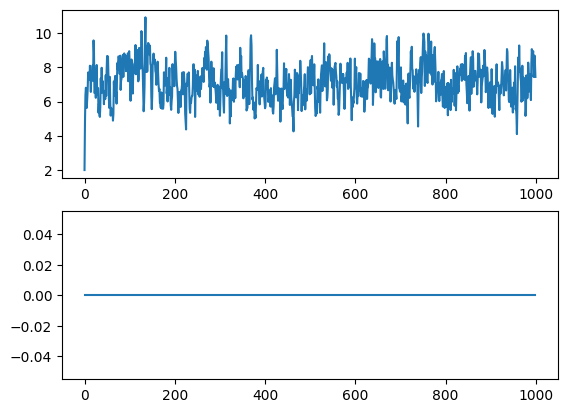

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()

axes[0].plot(losses_primal)
#axes[0].axhline(y=opt_lqr, color='r', linestyle='--')
axes[1].plot(losses_dual)
plt.show()

In [73]:
T = 100
states, actions = sampler.sample_trajectory(K, T)

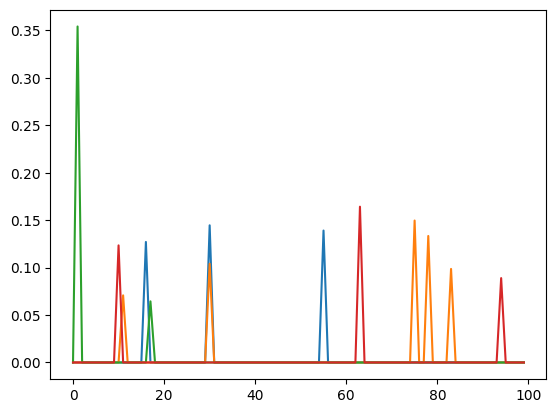

In [74]:
plt.plot(states[:, 0])
plt.plot(states[:, 1])
plt.plot(states[:, 2])
plt.plot(states[:, 3])
plt.show()

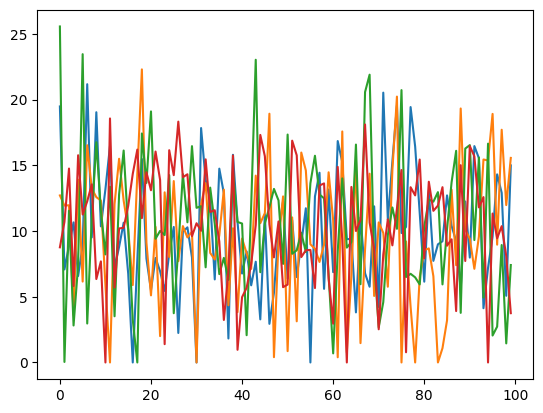

In [75]:
plt.plot(states[:, 4])
plt.plot(states[:, 5])
plt.plot(states[:, 6])
plt.plot(states[:, 7])
plt.show()

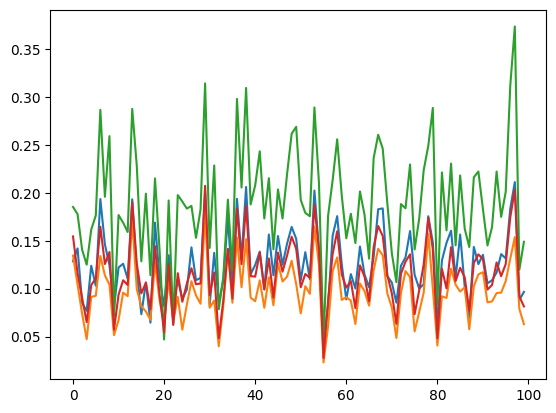

In [72]:
plt.plot(states[:, 8])
plt.plot(states[:, 9])
plt.plot(states[:, 10])
plt.plot(states[:, 11])
plt.show()